In [ ]:
# ================================
#  Environment setup (Colab)
# ================================
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
print("✅ PyTorch & PyG install attempted.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.3 MB/s eta 0:00:00
✅ PyTorch & PyG install attempted.


In [ ]:
# ================================
#  Imports & Utilities
# ================================
import os, random, copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import to_undirected, subgraph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3ji

Device: cuda


In [ ]:
# ================================
#  Load Cora + 7/1/2 split
# ================================
dataset = Planetoid(root='/content/data/Cora', name='Cora')
data = dataset[0]

def make_split(data, train_ratio=0.7, val_ratio=0.1, seed=1):
    g = torch.Generator().manual_seed(seed)
    idx = torch.randperm(data.num_nodes, generator=g)
    n = data.num_nodes
    n_tr = int(n*train_ratio); n_va = int(n*val_ratio)
    train_idx = idx[:n_tr]; val_idx = idx[n_tr:n_tr+n_va]; test_idx = idx[n_tr+n_va:]
    data.train_mask = torch.zeros(n, dtype=torch.bool); data.train_mask[train_idx]=True
    data.val_mask   = torch.zeros(n, dtype=torch.bool); data.val_mask[val_idx]=True
    data.test_mask  = torch.zeros(n, dtype=torch.bool); data.test_mask[test_idx]=True
    return data

data = make_split(data, 0.7, 0.1, seed=1)
data.edge_index = to_undirected(data.edge_index)

num_feats   = dataset.num_node_features
num_classes = dataset.num_classes
print(data)
print('Features:', num_feats, '| Classes:', num_classes)


Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Features: 1433 | Classes: 7


Done!


In [ ]:
# ================================
#  Config (paper-ish)
# ================================
CFG = dict(
    # suspect pools (train/test for the Univerifier)
    POS_TRAIN=50, POS_TEST=50,
    NEG_TRAIN=50, NEG_TEST=50,

    # which positive transforms to include
    USE_FT_LAST=True, USE_FT_ALL=True,
    USE_PR_LAST=True, USE_PR_ALL=True,
    USE_DISTILL=True,       # set False if runtime tight
    DISTILL_STEPS=250,      # paper ~1000; increase if GPU/time allows

    # fingerprints
    FP_P=64,            # number of fingerprints
    FP_NODES=32,        # nodes per fingerprint graph
    FP_SAMPLE_M=32,     # sampled nodes per fingerprint (<= FP_NODES)
    FP_EDGE_INIT_P=0.05,
    FP_EDGE_TOPK=96,
    EDGE_LOGIT_STEP=2.5,

    # training schedule
    OUTER_ITERS=20,     # OUTER_ITERS * V_STEPS ≈ 1000 verifier updates
    FP_STEPS=5,         # e1
    V_STEPS=10,         # e2

    # lrs
    LR_TARGET=0.005,
    WD_TARGET=5e-4,
    LR_V=1e-3,          # Univerifier
    LR_X=1e-3,          # feature ascent (paper 0.001)

    SEED=1,
)
print(CFG)


{'POS_TRAIN': 50, 'POS_TEST': 50, 'NEG_TRAIN': 50, 'NEG_TEST': 50, 'USE_FT_LAST': True, 'USE_FT_ALL': True, 'USE_PR_LAST': True, 'USE_PR_ALL': True, 'USE_DISTILL': True, 'DISTILL_STEPS': 250, 'FP_P': 64, 'FP_NODES': 32, 'FP_SAMPLE_M': 32, 'FP_EDGE_INIT_P': 0.05, 'FP_EDGE_TOPK': 96, 'EDGE_LOGIT_STEP': 2.5, 'OUTER_ITERS': 20, 'FP_STEPS': 5, 'V_STEPS': 10, 'LR_TARGET': 0.005, 'WD_TARGET': 0.0005, 'LR_V': 0.001, 'LR_X': 0.001, 'SEED': 1}


In [ ]:
# ================================
#  Define 3-layer GNN models
# ================================
class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.conv3 = GCNConv(hidden, out_channels)
        self.dropout = dropout
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index); x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index); x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.conv3 = SAGEConv(hidden, out_channels)
        self.dropout = dropout
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index); x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index); x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x


In [ ]:
# ================================
#  Train helpers
# ================================
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum().item()
        accs.append(correct / int(mask.sum()))
    return accs

def train_node_classifier(model, data, epochs=20, lr=0.005, wd=5e-4):
    model = model.to(device); data = data.to(device)
    opt = Adam(model.parameters(), lr=lr, weight_decay=wd)
    best = {'val': 0.0, 'state': None}
    for ep in range(epochs):
        model.train(); opt.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward(); opt.step()
        tr, va, te = evaluate(model, data)
        if va > best['val']:
            best['val'] = va; best['state'] = copy.deepcopy(model.state_dict())
        if ep % 5 == 0:
            print(f"Epoch {ep:03d} | loss {loss.item():.4f} | train {tr:.3f} | val {va:.3f} | test {te:.3f}")
    if best['state'] is not None:
        model.load_state_dict(best['state'])
    tr, va, te = evaluate(model, data)
    print(f"✅ Final (best-val) | train {tr:.3f} | val {va:.3f} | test {te:.3f}")
    return model


In [ ]:
# ================================
#  Train target model f (GCN)
# ================================
set_seed(CFG["SEED"])
model_f = GCN(num_feats, hidden=16, out_channels=num_classes, dropout=0.5)
model_f = train_node_classifier(model_f, data, epochs=200, lr=CFG["LR_TARGET"], wd=CFG["WD_TARGET"])


Epoch 000 | loss 1.9508 | train 0.260 | val 0.274 | test 0.249
Epoch 005 | loss 1.8069 | train 0.404 | val 0.407 | test 0.381
Epoch 010 | loss 1.6046 | train 0.475 | val 0.478 | test 0.455
Epoch 015 | loss 1.3610 | train 0.597 | val 0.578 | test 0.589
Epoch 020 | loss 1.1607 | train 0.723 | val 0.700 | test 0.692
Epoch 025 | loss 0.9737 | train 0.825 | val 0.789 | test 0.779
Epoch 030 | loss 0.8043 | train 0.876 | val 0.819 | test 0.843
Epoch 035 | loss 0.6812 | train 0.893 | val 0.848 | test 0.862
Epoch 040 | loss 0.6077 | train 0.908 | val 0.859 | test 0.867
Epoch 045 | loss 0.5333 | train 0.916 | val 0.859 | test 0.875
Epoch 050 | loss 0.4881 | train 0.918 | val 0.848 | test 0.877
Epoch 055 | loss 0.4272 | train 0.923 | val 0.856 | test 0.873
Epoch 060 | loss 0.4195 | train 0.926 | val 0.852 | test 0.877
Epoch 065 | loss 0.3875 | train 0.929 | val 0.844 | test 0.875
Epoch 070 | loss 0.3785 | train 0.929 | val 0.848 | test 0.867
Epoch 075 | loss 0.3670 | train 0.935 | val 0.852 | tes

In [ ]:
# =========================================
#  Build suspect models (F+ and F−)  [BUDGETED]
# =========================================
@torch.no_grad()
def reset_module(m):
    for layer in m.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def ft_model(base_model, data, last_only=True, epochs=10, lr=0.005, seed=123):
    set_seed(seed)
    m = copy.deepcopy(base_model).to(device)
    for p in m.parameters(): p.requires_grad_(not last_only)
    for p in m.conv3.parameters(): p.requires_grad_(True)  # last layer fine-tune
    opt = Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=lr)
    for _ in range(epochs):
        m.train(); opt.zero_grad()
        out = m(data.x.to(device), data.edge_index.to(device))
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward(); opt.step()
    return m.eval()

def pr_model(base_model, data, last_only=True, epochs=10, lr=0.005, seed=456):
    set_seed(seed)
    m = copy.deepcopy(base_model).to(device)
    if last_only: reset_module(m.conv3)
    else:         reset_module(m)
    opt = Adam(m.parameters(), lr=lr)
    for _ in range(epochs):
        m.train(); opt.zero_grad()
        out = m(data.x.to(device), data.edge_index.to(device))
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward(); opt.step()
    return m.eval()

def make_student(arch='GCN', hidden=16):
    return (GCN(num_feats, hidden, num_classes, dropout=0.5).to(device)
            if arch=='GCN' else
            GraphSAGE(num_feats, hidden, num_classes, dropout=0.5).to(device))

def random_subgraph_idx(n, keep_ratio=0.6, seed=7):
    g = torch.Generator().manual_seed(seed)
    keep = int(n*keep_ratio)
    return torch.randperm(n, generator=g)[:keep]

def distill_from_teacher(teacher, data, arch='GCN', T=2.0, steps=250, lr=0.01, seed=777):
    set_seed(seed)
    student = make_student(arch, hidden=16)
    opt = Adam(student.parameters(), lr=lr)
    kl = nn.KLDivLoss(reduction='batchmean')
    x_all = data.x.to(device); ei_all = data.edge_index.to(device)
    for t in range(steps):
        keep_ratio = float(torch.empty(1).uniform_(0.5, 0.8))
        idx = random_subgraph_idx(data.num_nodes, keep_ratio=keep_ratio, seed=seed+t).to(device)
        ei_sub, _ = subgraph(idx, ei_all, relabel_nodes=True)
        x_sub = x_all[idx]
        with torch.no_grad():
            p_t = F.softmax(teacher(x_sub, ei_sub)/T, dim=-1)
        student.train(); opt.zero_grad()
        logit_s = student(x_sub, ei_sub)/T
        loss = kl(F.log_softmax(logit_s, dim=-1), p_t) * (T*T)
        loss.backward(); opt.step()
    return student.eval()

# ---- budget splitter ----
def _distribute_budget(total, keys):
    if not keys: return {}
    base = total // len(keys); rem = total - base*len(keys)
    out = {k: base for k in keys}
    for k in keys[:rem]: out[k] += 1
    return out

# ===== Positives (F+) =====
F_pos_all = []
pos_total = CFG["POS_TRAIN"] + CFG["POS_TEST"]
pos_keys = []
if CFG["USE_FT_LAST"]: pos_keys.append("FT_LAST")
if CFG["USE_FT_ALL"]:  pos_keys.append("FT_ALL")
if CFG["USE_PR_LAST"]: pos_keys.append("PR_LAST")
if CFG["USE_PR_ALL"]:  pos_keys.append("PR_ALL")
if CFG["USE_DISTILL"]: pos_keys.append("DISTILL")
pos_budget = _distribute_budget(pos_total, pos_keys)

seed_base = 10
for key in pos_keys:
    cnt = pos_budget[key]
    if key == "FT_LAST":
        for s in range(seed_base, seed_base+cnt):
            F_pos_all.append(ft_model(model_f, data, last_only=True,  epochs=10, seed=s))
        seed_base += cnt
    elif key == "FT_ALL":
        for s in range(seed_base, seed_base+cnt):
            F_pos_all.append(ft_model(model_f, data, last_only=False, epochs=10, seed=s))
        seed_base += cnt
    elif key == "PR_LAST":
        for s in range(seed_base, seed_base+cnt):
            F_pos_all.append(pr_model(model_f, data, last_only=True,  epochs=10, seed=s))
        seed_base += cnt
    elif key == "PR_ALL":
        for s in range(seed_base, seed_base+cnt):
            F_pos_all.append(pr_model(model_f, data, last_only=False, epochs=10, seed=s))
        seed_base += cnt
    elif key == "DISTILL":
        arches = (['GCN'] * (cnt//2) + ['SAGE'] * (cnt - cnt//2))
        for i, arch in enumerate(arches, 400):
            F_pos_all.append(distill_from_teacher(model_f, data, arch=arch,
                                                  T=2.0, steps=CFG["DISTILL_STEPS"], seed=1000+i))
        seed_base += cnt

assert len(F_pos_all) == pos_total, f"Expected {pos_total} positives, got {len(F_pos_all)}"

# ===== Negatives (F−) =====
F_neg_all = []
neg_total = CFG["NEG_TRAIN"] + CFG["NEG_TEST"]
neg_keys = ["GCN", "SAGE"]
neg_budget = _distribute_budget(neg_total, neg_keys)

seed_base = 500
for s in range(seed_base, seed_base+neg_budget["GCN"]):
    set_seed(s)
    m = GCN(num_feats, 16, num_classes, dropout=0.5)
    m = train_node_classifier(m, data, epochs=120, lr=CFG["LR_TARGET"], wd=CFG["WD_TARGET"])
    F_neg_all.append(m.eval())
seed_base += neg_budget["GCN"]
for s in range(seed_base, seed_base+neg_budget["SAGE"]):
    set_seed(s)
    m = GraphSAGE(num_feats, 32, num_classes, dropout=0.5)
    m = train_node_classifier(m, data, epochs=120, lr=CFG["LR_TARGET"], wd=CFG["WD_TARGET"])
    F_neg_all.append(m.eval())

# ===== Train/Test split =====
def split_pool(pool, n_train, n_test, seed=999):
    set_seed(seed)
    idx = torch.randperm(len(pool)).tolist()
    train = [pool[i] for i in idx[:n_train]]
    test  = [pool[i] for i in idx[n_train:n_train+n_test]]
    return train, test

F_pos_tr, F_pos_te = split_pool(F_pos_all, CFG["POS_TRAIN"], CFG["POS_TEST"])
F_neg_tr, F_neg_te = split_pool(F_neg_all, CFG["NEG_TRAIN"], CFG["NEG_TEST"])

print(f"F+ train/test: {len(F_pos_tr)}/{len(F_pos_te)} | F- train/test: {len(F_neg_tr)}/{len(F_neg_te)} (totals match budgets)")


Epoch 000 | loss 1.9441 | train 0.396 | val 0.363 | test 0.365
Epoch 005 | loss 1.7581 | train 0.468 | val 0.474 | test 0.484
Epoch 010 | loss 1.5190 | train 0.574 | val 0.556 | test 0.575
Epoch 015 | loss 1.2952 | train 0.664 | val 0.652 | test 0.641
Epoch 020 | loss 1.0907 | train 0.725 | val 0.722 | test 0.722
Epoch 025 | loss 0.9218 | train 0.757 | val 0.752 | test 0.744
Epoch 030 | loss 0.7933 | train 0.804 | val 0.778 | test 0.781
Epoch 035 | loss 0.6964 | train 0.838 | val 0.819 | test 0.794
Epoch 040 | loss 0.6094 | train 0.883 | val 0.848 | test 0.832
Epoch 045 | loss 0.5599 | train 0.911 | val 0.881 | test 0.856
Epoch 050 | loss 0.5101 | train 0.922 | val 0.881 | test 0.864
Epoch 055 | loss 0.4687 | train 0.926 | val 0.870 | test 0.877
Epoch 060 | loss 0.4421 | train 0.927 | val 0.874 | test 0.871
Epoch 065 | loss 0.3879 | train 0.934 | val 0.867 | test 0.871
Epoch 070 | loss 0.3642 | train 0.934 | val 0.867 | test 0.867
Epoch 075 | loss 0.3654 | train 0.938 | val 0.867 | tes

In [ ]:
# =======================================================
#  Fingerprint set for node-level (P fingerprints)
# =======================================================
class FingerprintGraph(nn.Module):
    def __init__(self, n_nodes, feat_dim, sample_m, edge_init_p=0.05):
        super().__init__()
        self.n = n_nodes
        self.d = feat_dim
        self.m = min(sample_m, n_nodes)

        X = torch.empty(self.n, self.d).uniform_(-0.5, 0.5)
        self.X = nn.Parameter(X.to(device))

        A0 = (torch.rand(self.n, self.n, device=device) < edge_init_p).float()
        A0.fill_diagonal_(0.0)
        A0 = torch.maximum(A0, A0.T)
        self.A_logits = nn.Parameter(torch.logit(torch.clamp(A0, 1e-4, 1-1e-4)))

        self.sample_idx = torch.randperm(self.n, device=device)[:self.m]

    @torch.no_grad()
    def edge_index(self):
        A_prob = torch.sigmoid(self.A_logits)
        A_bin = (A_prob > 0.5).float()
        A_bin.fill_diagonal_(0.0)
        A_bin = torch.maximum(A_bin, A_bin.T)
        idx = A_bin.nonzero(as_tuple=False)
        if idx.numel() == 0:
            return torch.empty(2, 0, dtype=torch.long, device=device)
        return idx.t().contiguous()

    @torch.no_grad()
    def flip_topk_by_grad(self, gradA, topk=64, step=2.5):
        g = gradA.abs()
        triu = torch.triu(torch.ones_like(g), diagonal=1)
        scores = (g * triu).flatten()
        k = min(topk, scores.numel())
        if k == 0: return
        _, idxs = torch.topk(scores, k=k)
        r = self.n
        pairs = torch.stack((idxs // r, idxs % r), dim=1)
        A_prob = torch.sigmoid(self.A_logits).detach()
        for (u, v) in pairs.tolist():
            guv = gradA[u, v].item()
            exist = A_prob[u, v] > 0.5
            if exist and guv <= 0:
                self.A_logits.data[u, v] -= step
                self.A_logits.data[v, u] -= step
            elif (not exist) and guv >= 0:
                self.A_logits.data[u, v] += step
                self.A_logits.data[v, u] += step
        self.A_logits.data.fill_diagonal_(-10.0)

class FingerprintSet(nn.Module):
    def __init__(self, P, n_nodes, feat_dim, sample_m, edge_init_p=0.05, topk_edges=64, edge_step=2.5):
        super().__init__()
        self.P = P
        self.fps = nn.ModuleList([FingerprintGraph(n_nodes, feat_dim, sample_m, edge_init_p) for _ in range(P)]).to(device)
        self.topk_edges = topk_edges
        self.edge_step = edge_step

    def concat_outputs(self, model, *, require_grad: bool = False):
        outs = []
        model.eval()
        ctx = torch.enable_grad() if require_grad else torch.no_grad()
        with ctx:
            for fp in self.fps:
                ei = fp.edge_index()
                logits = model(fp.X, ei)
                probs  = F.softmax(logits, dim=-1)[fp.sample_idx].flatten()
                outs.append(probs)
        return torch.cat(outs, dim=0)

    def flip_adj_by_grad(self, surrogate_grad_list):
        for fp, g in zip(self.fps, surrogate_grad_list):
            fp.flip_topk_by_grad(g, topk=self.topk_edges, step=self.edge_step)

fp_set = FingerprintSet(
    P=CFG["FP_P"],
    n_nodes=CFG["FP_NODES"],
    feat_dim=num_feats,
    sample_m=CFG["FP_SAMPLE_M"],
    edge_init_p=CFG["FP_EDGE_INIT_P"],
    topk_edges=CFG["FP_EDGE_TOPK"],
    edge_step=CFG["EDGE_LOGIT_STEP"],
)

INPUT_DIM = CFG["FP_P"] * min(CFG["FP_SAMPLE_M"], CFG["FP_NODES"]) * num_classes
print("Univerifier input dim =", INPUT_DIM)


Univerifier input dim = 14336


In [ ]:
# ========================================
#  Univerifier (binary classifier)
# ========================================
class Univerifier(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.LeakyReLU(0.01),
            nn.Linear(128, 64),       nn.LeakyReLU(0.01),
            nn.Linear(64, 32),        nn.LeakyReLU(0.01),
            nn.Linear(32, 2),
        )
    def forward(self, x):
        return self.net(x)

V = Univerifier(INPUT_DIM).to(device)
opt_V = Adam(V.parameters(), lr=CFG["LR_V"])


In [ ]:
# =====================================================
#  Joint learning (Algorithm-1 for node-level)
# =====================================================
models_pos_tr = [model_f.to(device)] + [m.to(device) for m in F_pos_tr]
models_neg_tr = [m.to(device) for m in F_neg_tr]
print(f"Train pools -> Pos: {len(models_pos_tr)} | Neg: {len(models_neg_tr)}")

def batch_from_pool(fp_set, pos_models, neg_models, *, require_grad: bool):
    X = []; y = []
    for m in pos_models:
        X.append(fp_set.concat_outputs(m, require_grad=require_grad)); y.append(1)
    for m in neg_models:
        X.append(fp_set.concat_outputs(m, require_grad=require_grad)); y.append(0)
    return torch.stack(X, dim=0), torch.tensor(y, device=device)

def surrogate_grad_A_for_fp(fp, model):
    # cosine-sim surrogate gradient from target model's first layer
    with torch.no_grad():
        ei = fp.edge_index()
        h  = model.conv1(fp.X, ei)
        h  = F.relu(h)
        hn = F.normalize(h, dim=-1)
        sim = hn @ hn.t()
        gradA = sim - 0.5
        return gradA.detach().cpu()

def update_features(fp_set, V, pos_models, neg_models, steps, lr_x):
    # freeze model params
    for m in pos_models + neg_models:
        for p in m.parameters(): p.requires_grad_(False)
    # turn on grad for X before building batch
    for fp in fp_set.fps:
        fp.X.requires_grad_(True)

    for _ in range(steps):
        Xb, yb = batch_from_pool(fp_set, pos_models, neg_models, require_grad=True)
        V.eval()
        for p in V.parameters(): p.requires_grad_(False)

        logits = V(Xb.to(device))
        loss = F.cross_entropy(logits, yb)

        for fp in fp_set.fps:
            if fp.X.grad is not None: fp.X.grad.zero_()
        loss.backward()

        with torch.no_grad():
            for fp in fp_set.fps:
                fp.X.add_(lr_x * fp.X.grad)
                fp.X.grad.zero_()

        for p in V.parameters(): p.requires_grad_(True)

    grads = [surrogate_grad_A_for_fp(fp, pos_models[0]) for fp in fp_set.fps]
    fp_set.flip_adj_by_grad(grads)

def update_verifier(fp_set, V, pos_models, neg_models, steps):
    for _ in range(steps):
        V.train()
        Xb, yb = batch_from_pool(fp_set, pos_models, neg_models, require_grad=False)
        logits = V(Xb.to(device))
        loss = F.cross_entropy(logits, yb)
        opt_V.zero_grad(); loss.backward(); opt_V.step()

for it in range(1, CFG["OUTER_ITERS"] + 1):
    update_features(fp_set, V, models_pos_tr, models_neg_tr, steps=CFG["FP_STEPS"], lr_x=CFG["LR_X"])
    update_verifier(fp_set, V, models_pos_tr, models_neg_tr, steps=CFG["V_STEPS"])

    V.eval()
    Xb, yb = batch_from_pool(fp_set, models_pos_tr, models_neg_tr, require_grad=False)
    with torch.no_grad():
        pred = V(Xb).argmax(dim=1)
        acc = (pred.cpu() == yb.cpu()).float().mean().item()
        pos_acc = (pred[:len(models_pos_tr)].cpu() == 1).float().mean().item()
        neg_acc = (pred[len(models_pos_tr):].cpu() == 0).float().mean().item()
    print(f"Iter {it:02d}/{CFG['OUTER_ITERS']} | train all {acc:.3f} | pos {pos_acc:.3f} | neg {neg_acc:.3f}")


Train pools -> Pos: 51 | Neg: 50
Iter 01/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 02/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 03/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 04/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 05/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 06/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 07/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 08/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 09/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 10/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 11/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 12/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 13/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 14/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 15/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 16/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 17/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 18/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 19/20 | 

In [ ]:
# ==========================================================
#  Held-out verification (Robustness/Uniqueness/ARUC)
# ==========================================================
models_pos_te = [model_f.to(device)] + [m.to(device) for m in F_pos_te]
models_neg_te = [m.to(device) for m in F_neg_te]

@torch.no_grad()
def verify_scores(V, fp_set, models):
    Xs = [fp_set.concat_outputs(m, require_grad=False) for m in models]
    logits = V(torch.stack(Xs, dim=0).to(device))
    probs = F.softmax(logits, dim=-1)[:, 1]  # p(positive)
    return probs.detach().cpu().numpy()

p_pos = verify_scores(V, fp_set, models_pos_te)
p_neg = verify_scores(V, fp_set, models_neg_te)

def sweep_threshold(p_pos, p_neg, num=301):
    ths = np.linspace(0.0, 1.0, num=num)
    R = []; U = []; A = []
    for t in ths:
        tp = (p_pos >= t).mean()    # robustness
        tn = (p_neg <  t).mean()    # uniqueness
        R.append(tp); U.append(tn)
        A.append((tp + tn) / 2.0)   # balanced acc (pos/neg equal)
    return ths, np.array(R), np.array(U), np.array(A)

ths, R, U, A = sweep_threshold(p_pos, p_neg, num=301)
best_idx = A.argmax()
mean_acc = A.mean()

# numpy>=2.0 has trapezoid; fallback to trapz if unavailable
ARUC = np.trapezoid(np.minimum(R, U), ths) if hasattr(np, "trapezoid") else np.trapz(np.minimum(R, U), ths)

print(f"Best @ λ={ths[best_idx]:.3f} | Robustness={R[best_idx]:.3f} | Uniqueness={U[best_idx]:.3f} | MeanAcc*={A[best_idx]:.3f}")
print(f"Mean Test Accuracy (avg over λ): {mean_acc:.3f}")
print(f"ARUC (approx): {ARUC:.3f}")


Best @ λ=0.013 | Robustness=1.000 | Uniqueness=1.000 | MeanAcc*=1.000
Mean Test Accuracy (avg over λ): 0.997
ARUC (approx): 0.997


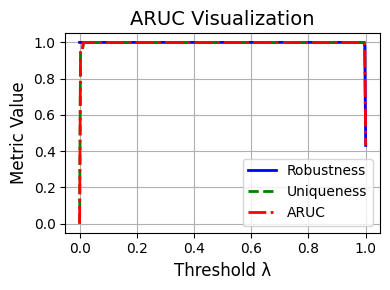

Best @ λ=0.013 | Robustness=1.000 | Uniqueness=1.000 | MeanAcc*=1.000
Mean Test Accuracy (avg over λ): 0.997
ARUC (approx): 0.997


In [ ]:
# ================================
#  ARUC Visualization (Plotting)
# ================================
import matplotlib.pyplot as plt

# Plot ARUC curve
plt.figure(figsize=(4, 3))

# Plot Robustness
plt.plot(ths, R, label="Robustness", color='b', linestyle='-', linewidth=2)

# Plot Uniqueness
plt.plot(ths, U, label="Uniqueness", color='g', linestyle='--', linewidth=2)

# Plot ARUC (area under curve of the minimum of robustness and uniqueness)
plt.plot(ths, np.minimum(R, U), label="ARUC", color='r', linestyle='-.', linewidth=2)

# Plot Formatting
plt.xlabel('Threshold λ', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('ARUC Visualization', fontsize=14)
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Print ARUC value for reference
print(f"Best @ λ={ths[best_idx]:.3f} | Robustness={R[best_idx]:.3f} | Uniqueness={U[best_idx]:.3f} | MeanAcc*={A[best_idx]:.3f}")
print(f"Mean Test Accuracy (avg over λ): {mean_acc:.3f}")
print(f"ARUC (approx): {ARUC:.3f}")


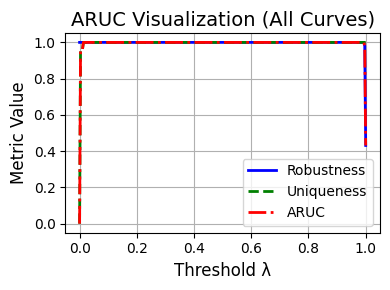

Best @ λ=0.013 | Robustness=1.000 | Uniqueness=1.000 | ARUC=1.000


In [ ]:
# ================================
#  Plot All Curves Together
# ================================
plt.figure(figsize=(4, 3))

# Plot Robustness
plt.plot(ths, R, label="Robustness", color='b', linestyle='-', linewidth=2)

# Plot Uniqueness
plt.plot(ths, U, label="Uniqueness", color='g', linestyle='--', linewidth=2)

# Plot ARUC
plt.plot(ths, np.minimum(R, U), label="ARUC", color='r', linestyle='-.', linewidth=2)

# Plot Formatting
plt.xlabel('Threshold λ', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('ARUC Visualization (All Curves)', fontsize=14)
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Print corresponding values
print(f"Best @ λ={ths[best_idx]:.3f} | Robustness={R[best_idx]:.3f} | Uniqueness={U[best_idx]:.3f} | ARUC={np.minimum(R, U)[best_idx]:.3f}")


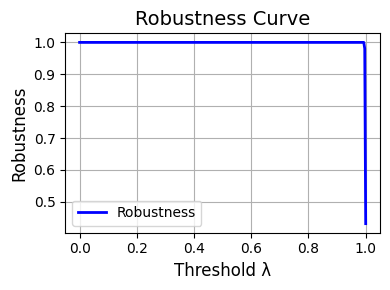

Best @ λ=0.013 | Robustness=1.000


In [ ]:
# ================================
#  Plot Robustness Curve
# ================================
plt.figure(figsize=(4, 3))

# Plot Robustness
plt.plot(ths, R, label="Robustness", color='b', linestyle='-', linewidth=2)

# Plot Formatting
plt.xlabel('Threshold λ', fontsize=12)
plt.ylabel('Robustness', fontsize=12)
plt.title('Robustness Curve', fontsize=14)
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Print corresponding values
print(f"Best @ λ={ths[best_idx]:.3f} | Robustness={R[best_idx]:.3f}")


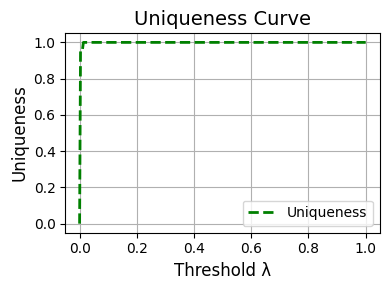

Best @ λ=0.013 | Uniqueness=1.000


In [ ]:
# ================================
#  Plot Uniqueness Curve
# ================================
plt.figure(figsize=(4, 3))

# Plot Uniqueness
plt.plot(ths, U, label="Uniqueness", color='g', linestyle='--', linewidth=2)

# Plot Formatting
plt.xlabel('Threshold λ', fontsize=12)
plt.ylabel('Uniqueness', fontsize=12)
plt.title('Uniqueness Curve', fontsize=14)
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Print corresponding values
print(f"Best @ λ={ths[best_idx]:.3f} | Uniqueness={U[best_idx]:.3f}")


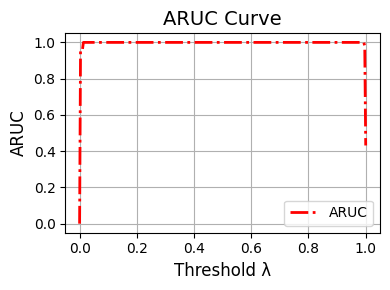

Best @ λ=0.013 | ARUC=1.000


In [ ]:
# ================================
#  Plot ARUC Curve
# ================================
plt.figure(figsize=(4, 3))

# Plot ARUC (minimum of robustness and uniqueness)
plt.plot(ths, np.minimum(R, U), label="ARUC", color='r', linestyle='-.', linewidth=2)

# Plot Formatting
plt.xlabel('Threshold λ', fontsize=12)
plt.ylabel('ARUC', fontsize=12)
plt.title('ARUC Curve', fontsize=14)
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Print corresponding values
print(f"Best @ λ={ths[best_idx]:.3f} | ARUC={np.minimum(R, U)[best_idx]:.3f}")
